In [1]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt 

In [ ]:
current_dir = os.getcwd()
ROOT_PATH = os.path.dirname(current_dir)
sys.path.insert(1, ROOT_PATH)
import root

datos = pd.read_pickle(root.DIR_DATA_STAGE + 'merged_df.pkl')
datos = datos.set_index('datetime')
datos = datos.asfreq('h')

In [9]:
def load_datasets():
    """Load all datasets and return them as dataframes."""
    current_dir = os.getcwd()
    ROOT_PATH = os.path.dirname(current_dir)
    sys.path.insert(1, ROOT_PATH)
    sys.path.insert(1, current_dir)
    import root

    train = pd.read_pickle(root.DIR_DATA_STAGE + 'generation.pkl')
    client = pd.read_pickle(root.DIR_DATA_STAGE + 'client.pkl')
    historical_weather = pd.read_pickle(root.DIR_DATA_STAGE + 'historical_weather.pkl')
    electricity_prices = pd.read_pickle(root.DIR_DATA_STAGE + 'electricity_prices.pkl')
    gas_prices = pd.read_pickle(root.DIR_DATA_STAGE + 'gas_prices.pkl')  

    return  train, client, historical_weather, electricity_prices, gas_prices


def add_time_series_col(client, historical_weather, electricity_prices, gas_prices):
    """Add column with date where data is available."""

    client['datetime'] = pd.to_datetime(client['date']) + pd.Timedelta(days=3)
    historical_weather['datetime'] += pd.Timedelta(days=2)
    electricity_prices['datetime'] = pd.to_datetime(electricity_prices['forecast_date']) + pd.Timedelta(days=1)
    gas_prices['datetime'] = pd.to_datetime(gas_prices['forecast_date']) + pd.Timedelta(days=1)

    # Drop unnecessary columns after date adjustments
    client = client.drop(['date'], axis=1)
    electricity_prices = electricity_prices.drop(['forecast_date'], axis=1)
    gas_prices = gas_prices.drop(['forecast_date'], axis=1)

    return client, historical_weather, electricity_prices, gas_prices


def merge_datasets(train, client, historical_weather, electricity_prices, gas_prices):
    """Merge DataFrames train, client, historical weather, gas prices and electricity prices based on the datetime column."""
    merged = train.merge(historical_weather, on='datetime', how='left') \
                  .merge(electricity_prices, on='datetime', how='left')
    
    # Add dt.floor('D')
    merged['date'] = merged['datetime'].dt.floor('D')
    client['date'] = client['datetime'].dt.floor('D')
    client = client.drop('datetime', axis=1)
    gas_prices['date'] = gas_prices['datetime'].dt.floor('D')
    gas_prices = gas_prices.drop('datetime', axis=1)

    merged = merged.merge(client, on='date', how='outer') \
                   .merge(gas_prices, on='date', how='outer')

    #dreop unnecessary columns
    merged = merged.drop(['date'], axis=1)
    
    return merged


def reorder_columns(df, column_order=None):
    """Reorder columns of the DataFrame."""
    if column_order == None:
        column_order = [
            'datetime', 'target', 'temperature', 'dewpoint', 'rain', 'snowfall',
            'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 
            'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
            'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
            'lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh','eic_count', 'installed_capacity'
            ]
    return df[column_order]


def save_datasets_to_pickle(datasets, paths=None):
    """Save each dataset in datasets list to the corresponding path in paths list as a pickle file."""
    if paths == None:
        import root
        paths = [
            root.DIR_DATA_STAGE + 'merged_df.pkl',
        ]

    # Create folders if not exists
    for path in paths:
        os.makedirs(os.path.dirname(path), exist_ok=True)

    # Save each dataset to its respective path
    for dataset, path in zip(datasets, paths):
        dataset.to_pickle(path)


def drop_first_3_days(df, column, threshold_column, threshold_nans=70):
    """Drop first 3 days of the dataset if the threshold is exceeded."""
    # Count null values in the threshold column
    nulos = df[threshold_column].isna().sum()
    
    # If the threshold is exceeded drop the first 3 days
    if nulos > threshold_nans:
        # Initial date
        fecha_minima = df[column].min()
        # Limit day
        limite = fecha_minima + pd.Timedelta(days=3)
        # Filter df
        df = df[df[column] >= limite]
    
    return df


def feature_selection(df):
    cols_2_drop = [ 'dewpoint','cloudcover_low','cloudcover_mid', 
                   'cloudcover_high','direct_solar_radiation',
                   'diffuse_radiation', 'lowest_price_per_mwh',
                   'highest_price_per_mwh','eic_count']
    df.drop(columns = cols_2_drop, axis = 1, inplace = True)
    return df


def set_datetime_index(df):
    df = df.set_index('datetime')
    df = df.asfreq('h')
    return df


def merge():
     # Read datasets
    train, client, historical_weather, electricity_prices, gas_prices = load_datasets()

    # Prepare date columns for merging
    client, historical_weather, electricity_prices, gas_prices = add_time_series_col(client, historical_weather, electricity_prices, gas_prices)

    # Merge datasets
    merged = merge_datasets(train, client, historical_weather, electricity_prices, gas_prices)
    
    # Reorder dataset columns
    merged = reorder_columns(merged)
    
    # Drop first three days
    merged = drop_first_3_days(merged, 'datetime','installed_capacity')

    # Set datetime index
    merged = set_datetime_index(merged)

    # Save dataset to pickle file
    save_datasets_to_pickle([merged])
    
    return merged

In [10]:
datos = merge()

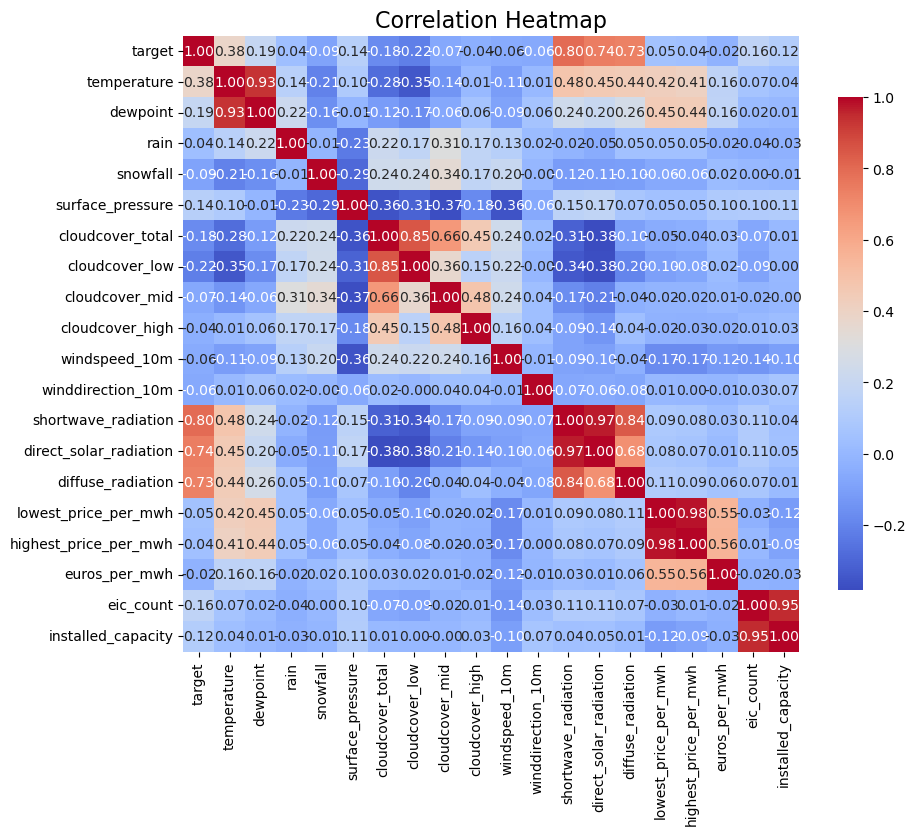

In [19]:
correlation_matrix = datos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [13]:
datos.columns

Index(['target', 'temperature', 'dewpoint', 'rain', 'snowfall',
       'surface_pressure', 'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh', 'eic_count', 'installed_capacity'],
      dtype='object')

# Filtro install capacity eic count

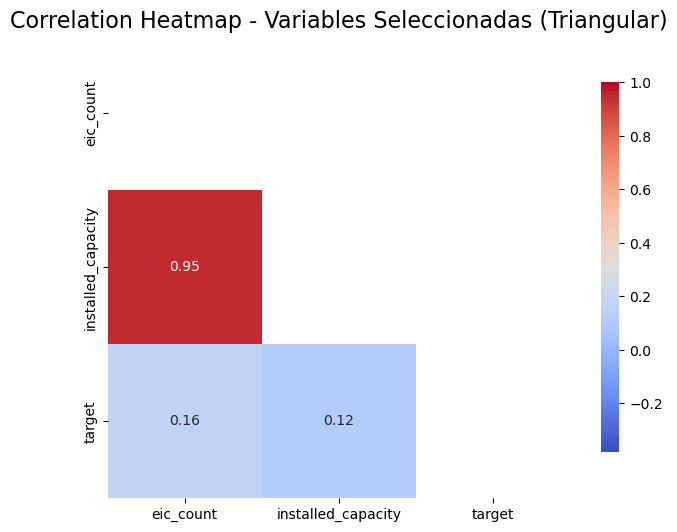

In [25]:
variables_interes = ['eic_count', 'installed_capacity','target']  # reemplaza con los nombres de las variables que te interesan

# Filtrar el DataFrame solo con esas variables
datos_interes = datos[variables_interes]

correlation_submatrix = correlation_matrix.loc[variables_interes, variables_interes]

# Obtener los valores mínimo y máximo de la matriz completa
vmin = correlation_matrix.min().min()
vmax = correlation_matrix.max().max()

mask = np.triu(np.ones_like(correlation_submatrix, dtype=bool))

# Graficar el mapa de calor triangular
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, vmin=vmin, vmax=vmax, mask=mask)
plt.title('Correlation Heatmap - Variables Seleccionadas (Triangular)', fontsize=16)
plt.show()

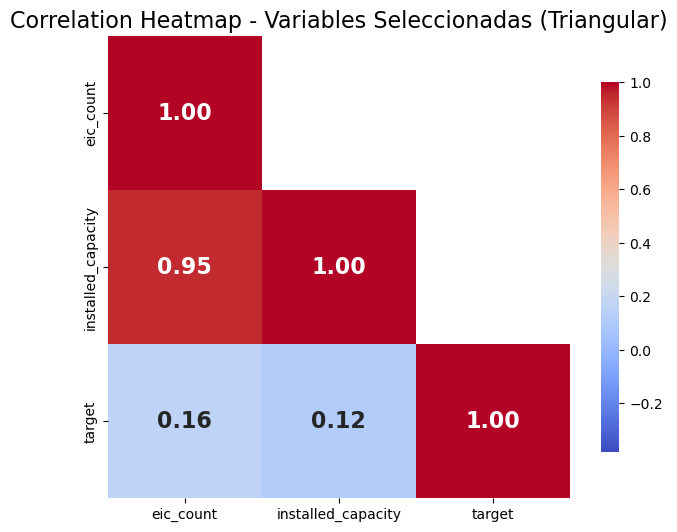

In [26]:
vmin = correlation_matrix.min().min()
vmax = correlation_matrix.max().max()

# Crear una máscara para la mitad superior, sin enmascarar la diagonal
mask = np.triu(np.ones_like(correlation_submatrix, dtype=bool), k=1)

# Graficar el mapa de calor triangular con la diagonal visible
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, vmin=vmin, vmax=vmax, mask=mask, 
            annot_kws={"size": 16, "weight": "bold"}) 
plt.title('Correlation Heatmap - Variables Seleccionadas (Triangular)', fontsize=16)
plt.show()

In [27]:
datos.columns

Index(['target', 'temperature', 'dewpoint', 'rain', 'snowfall',
       'surface_pressure', 'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh', 'eic_count', 'installed_capacity'],
      dtype='object')

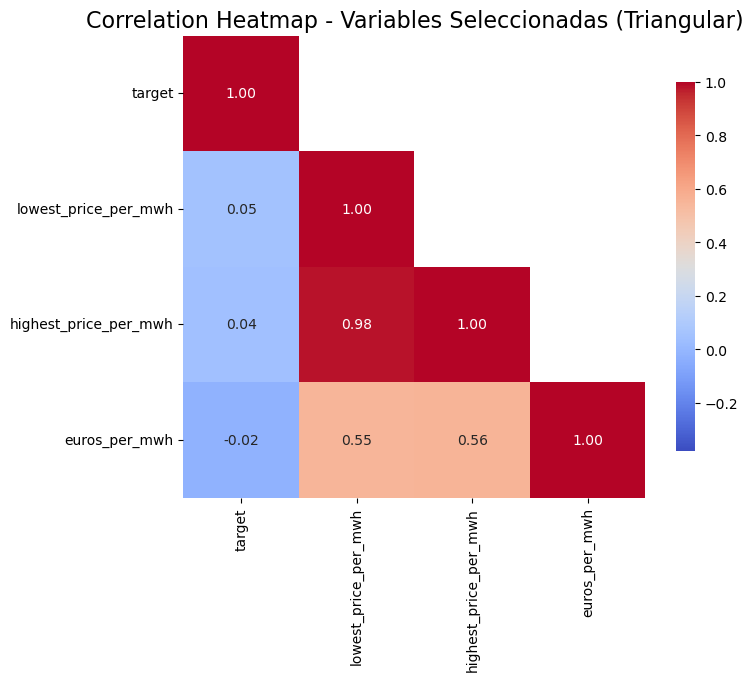

In [30]:
variables_interes = ['target','lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh']  # reemplaza con los nombres de las variables que te interesan

# Filtrar el DataFrame solo con esas variables
datos_interes = datos[variables_interes]

correlation_submatrix = correlation_matrix.loc[variables_interes, variables_interes]

# Obtener los valores mínimo y máximo de la matriz completa
vmin = correlation_matrix.min().min()
vmax = correlation_matrix.max().max()

mask = np.triu(np.ones_like(correlation_submatrix, dtype=bool), k = 1)

# Graficar el mapa de calor triangular
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, vmin=vmin, vmax=vmax, mask=mask)
plt.title('Correlation Heatmap - Variables Seleccionadas (Triangular)', fontsize=16)
plt.show()

In [4]:
datos.columns

Index(['target', 'temperature', 'dewpoint', 'rain', 'snowfall',
       'surface_pressure', 'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh', 'eic_count', 'installed_capacity'],
      dtype='object')

In [9]:
cols_2_drop = [ 'dewpoint',
       'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high','direct_solar_radiation',
       'diffuse_radiation', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'eic_count']

In [10]:
datos.drop(columns=cols_2_drop, inplace=True)

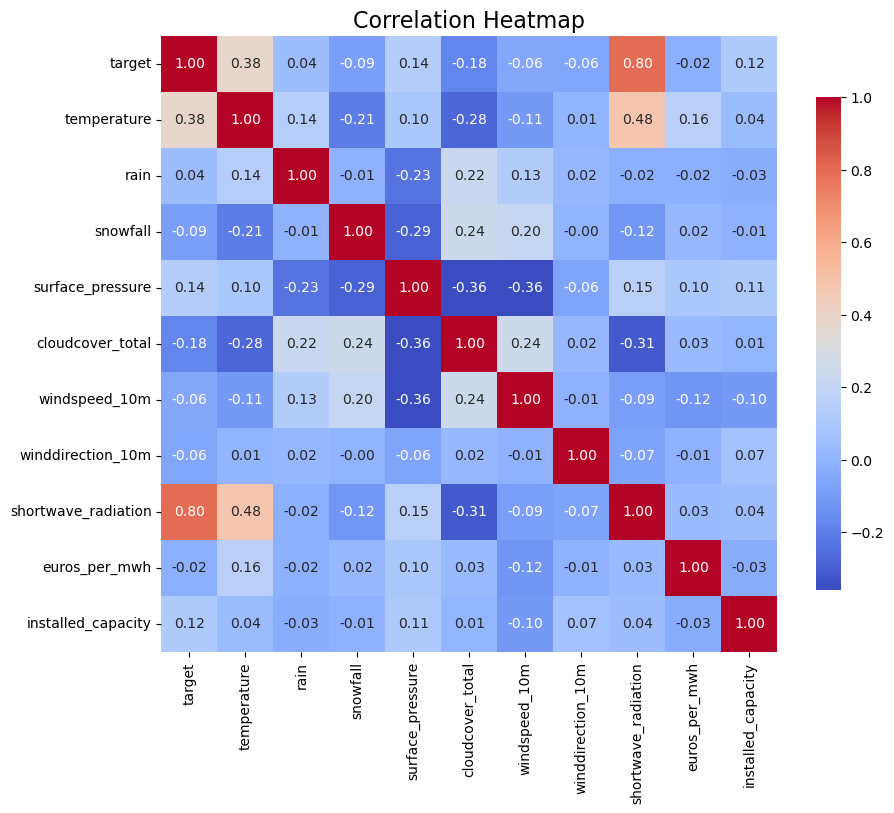

In [11]:
correlation_matrix = datos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()